# Single Shot MultiBox Detector - SSD

## Source
https://github.com/tanakataiki/ssd_kerasV2/blob/master/SSD.ipynb

## ติดตั้ง Library ที่จำเป็น

This code was tested with Keras v2.1.5, Tensorflow v1.6.0 GTX1080 Tensorflow・Keras・Numpy・Scipy・opencv-python・pillow・matplotlib・h5py

In [3]:
# library สำหรับโหลดไฟล์จาก google drive
!pip install gdown

In [0]:
!pip install tensorflow==1.6

In [4]:
# เลือกใช้ keras เวอร์ชัน 2.2.4
!pip install keras==2.2.4

     |████████████████████████████████| 317kB 8.7MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [5]:
!pip install Pillow

In [6]:
# clone โปรแกรม  ssd_kerasV2 จาก github
!git clone https://github.com/tanakataiki/ssd_kerasV2

Cloning into 'ssd_kerasV2'...
remote: Enumerating objects: 176, done.
remote: Total 176 (delta 0), reused 0 (delta 0), pack-reused 176
Receiving objects: 100% (176/176), 50.99 MiB | 25.75 MiB/s, done.
Resolving deltas: 100% (82/82), done.


In [7]:
%cd ssd_kerasV2

/content/ssd_kerasV2


In [8]:
%cd model
!touch __init__.py
%cd ..

/content/ssd_kerasV2/model
/content/ssd_kerasV2


## เริ่มต้นโปรแกรม

In [9]:
import cv2
import keras
from keras.applications.imagenet_utils import preprocess_input
from keras.backend.tensorflow_backend import set_session
from keras.models import Model
from keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
#from scipy.misc import imread
import tensorflow as tf

from imageio import imread

#from model.ssdMobileNet300 import SSD
#from model.ssd300MobileNetV2Lite import SSD
from model.ssd300MobileNet import SSD 
#from model.ssd300XceptionLite import SSD

from ssd_utils import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.45
set_session(tf.Session(config=config))

Using TensorFlow backend.


### จำนวน Class ทั้งหมด

In [10]:
voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']
NUM_CLASSES = len(voc_classes) + 1

print(NUM_CLASSES)

21


## weight ที่ใช้สำหรับ SSD
https://drive.google.com/drive/u/0/folders/1F8GjD3BFhf_hv9Ipez0twRptYc3P8YwP

In [13]:
%cd weights/
!gdown --id 1qnRNrmS3pe7tojCHjrRGo4i93XGGv6Vk
%cd ..

/content/ssd_kerasV2/weights
Downloading...
From: https://drive.google.com/uc?id=1qnRNrmS3pe7tojCHjrRGo4i93XGGv6Vk
To: /content/ssd_kerasV2/weights/MobileNetSSD300weights_voc_2007_class20.hdf5.hdf5 ____
28.8MB [00:00, 79.0MB/s]
/content/ssd_kerasV2


## โหลด Weight ไปใช้ในการ Predict

In [0]:
WEIGHT_PATH = '/content/ssd_kerasV2/weights/MobileNetSSD300weights_voc_2007_class20.hdf5.hdf5 ____'
input_shape =(300, 300, 3)
model = SSD(input_shape, num_classes=NUM_CLASSES)
model.load_weights(WEIGHT_PATH, by_name=True)
bbox_util = BBoxUtility(NUM_CLASSES)

In [0]:
def img_inference(images, results):

  for i, img in enumerate(images):
      # Parse the outputs.
      det_label = results[i][:, 0]
      det_conf = results[i][:, 1]
      det_xmin = results[i][:, 2]
      det_ymin = results[i][:, 3]
      det_xmax = results[i][:, 4]
      det_ymax = results[i][:, 5]

      # Get detections with confidence higher than 0.6.
      top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.6]

      top_conf = det_conf[top_indices]
      top_label_indices = det_label[top_indices].tolist()
      top_xmin = det_xmin[top_indices]
      top_ymin = det_ymin[top_indices]
      top_xmax = det_xmax[top_indices]
      top_ymax = det_ymax[top_indices]

      colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

      plt.imshow(img / 255.)
      currentAxis = plt.gca()

      for i in range(top_conf.shape[0]):
          xmin = int(round(top_xmin[i] * img.shape[1]))
          ymin = int(round(top_ymin[i] * img.shape[0]))
          xmax = int(round(top_xmax[i] * img.shape[1]))
          ymax = int(round(top_ymax[i] * img.shape[0]))
          score = top_conf[i]
          label = int(top_label_indices[i])
          label_name = voc_classes[label - 1]
          display_txt = '{:0.2f}, {}'.format(score, label_name)
          coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
          color = colors[label]
          currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
          currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
      
      plt.show()

In [17]:
inputs = []
images = []
#img_path = './pics/picture_name.jpg'
img_path = '/content/eng_lineup.png'

img = image.load_img(img_path, target_size=(300, 300))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

# predict & object detection
preds = model.predict(inputs, batch_size=1, verbose=1)

results = bbox_util.detection_out(preds)

1/1 [==============================] - 8s 8s/step


ทดสอบเวลาในการ detection

In [18]:
%%time
a = model.predict(inputs, batch_size=1)
b = bbox_util.detection_out(preds)

CPU times: user 16.3 ms, sys: 4.59 ms, total: 20.9 ms
Wall time: 20 ms


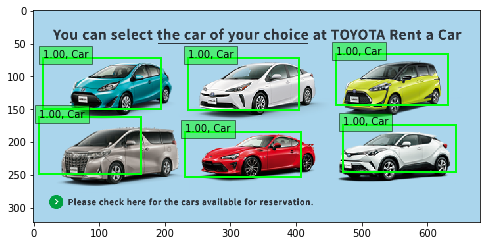

In [20]:
img_inference(images, results)

## สร้างฟังก์ชันอัพโหลดรูปใน colab

In [0]:
from google.colab import files

def upload_img():
  uploaded = files.upload()
  img_infer = list(uploaded)[0]
  print('Running inference on: ' + img_infer)

  inputs = []
  images = []

  img = image.load_img(img_infer, target_size=(300, 300))
  img = image.img_to_array(img)
  images.append(imread(img_infer))
  inputs.append(img.copy())
  inputs = preprocess_input(np.array(inputs))
  
  # predict & object detection
  preds = model.predict(inputs, batch_size=1, verbose=1)
  results = bbox_util.detection_out(preds)
  
  img_inference(images, results)

เรียกใช้งาน

Saving brett-hales-VuQSy84Yqzs-unsplash-1024x768.jpg to brett-hales-VuQSy84Yqzs-unsplash-1024x768.jpg
Running inference on: brett-hales-VuQSy84Yqzs-unsplash-1024x768.jpg
1/1 [==============================] - 0s 13ms/step


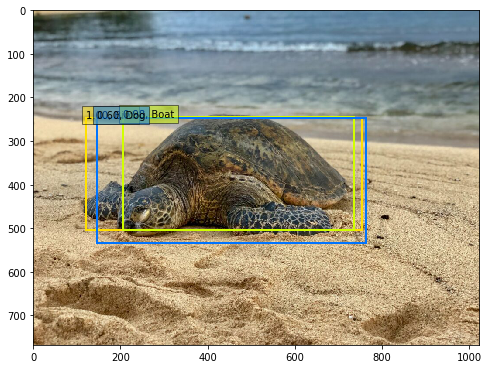

In [38]:
upload_img()

Saving Tesla-fleet-S3XY.jpg to Tesla-fleet-S3XY (3).jpg
Running inference on: Tesla-fleet-S3XY.jpg
1/1 [==============================] - 0s 13ms/step


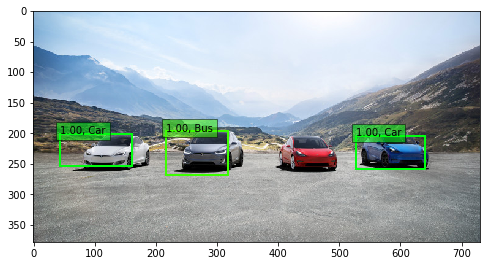

In [29]:
upload_img()

Saving eng_lineup.png to eng_lineup (1).png
Running inference on: eng_lineup.png
1/1 [==============================] - 0s 13ms/step


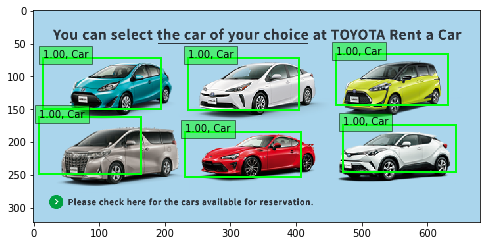

In [30]:
upload_img()

Saving Lambs-700px.jpg to Lambs-700px.jpg
Running inference on: Lambs-700px.jpg
1/1 [==============================] - 0s 13ms/step


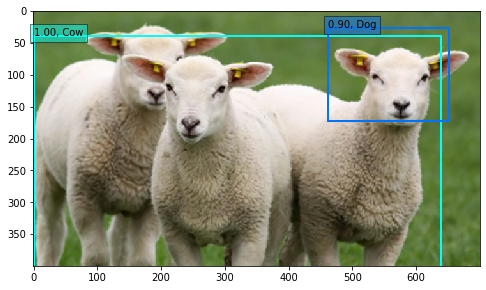

In [32]:
upload_img()

Saving Flock_of_sheep.jpg to Flock_of_sheep.jpg
Running inference on: Flock_of_sheep.jpg
1/1 [==============================] - 0s 14ms/step


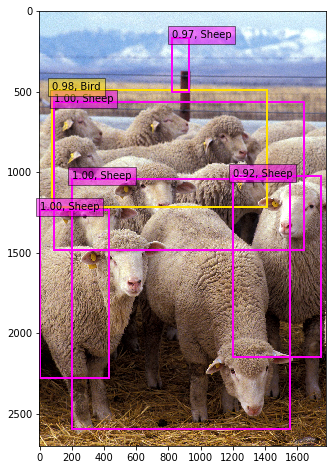

In [34]:
upload_img()

Saving 1012746.jpg to 1012746.jpg
Running inference on: 1012746.jpg
1/1 [==============================] - 0s 12ms/step


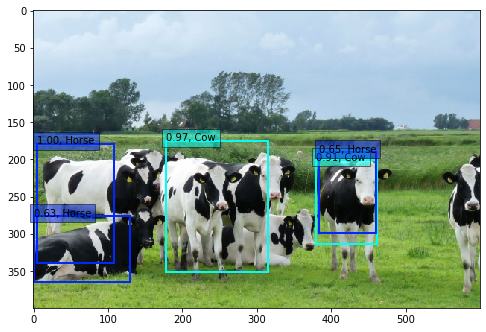

In [35]:
upload_img()

Saving person.jpg to person.jpg
Running inference on: person.jpg
1/1 [==============================] - 0s 15ms/step


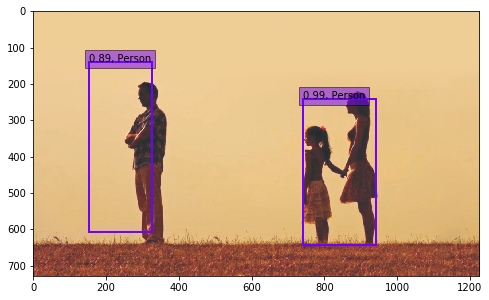

In [36]:
upload_img()

Saving depositphotos_3048477-stock-photo-pack-of-sheeps-on-the.jpg to depositphotos_3048477-stock-photo-pack-of-sheeps-on-the.jpg
Running inference on: depositphotos_3048477-stock-photo-pack-of-sheeps-on-the.jpg
1/1 [==============================] - 0s 12ms/step


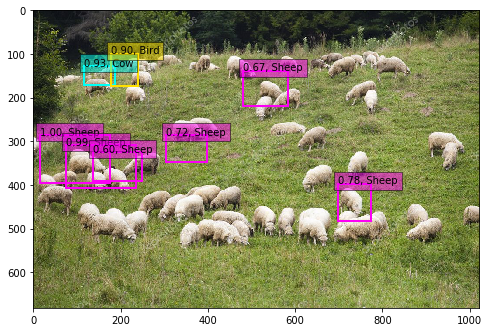

In [39]:
upload_img()